# Cheers - a beer recommendation engine from your search words

## Introduction

The number of different beers produced in the United States has increased from 10,000 to nearly 100,000 in the last decade. Several issues arise as a result of this. One, a beer's style, such as IPA, is meaningless because there are over 50k of them, each with its own distinct flavor profile. Second, how can one choose between a wall of beer in a liquor store or a tap list with hundreds of beers on tap?

Cheers is a beer recommendation engine to addresses both of these concerns by allowing users to search for beers based on how we actually choose beers: by describing the flavors we desire or beers in similar taste.

The deliverable of this project will be a web app. Using a dataset of reviews and descriptions from popular beer websites, the engine provides a list of beers using the maximum number of keywords specified by the user.  In just a single result page, each beer is listed along with its description, average rating, and a link that showing the list of places you can find it near your location.

## Data

  1. Beeradvocate.com: For each beer, its reviews, ratings, state,	country, and	style are scraped from beeradvocate.com.
  2. Ratebeer.com, Untappd.com, Beerconnoisseur.com, Influenster.com: Will be added after finizlizing the model.

## Model

These reviews and descriptions are quite useful because they include words that describe the properties of the beverage. Employing Natural Language Processing (NLP), we can find relationships between these descriptions and reviews. When the user enters their own search phrases, the engine discovers the most similar beer descriptions and returns their information. This allows consumers to identify beers that fit the flavors they're searching for right now, rather than proposing another highly ranked, but potentially quite different, beer.

| Embedding | Model | Train Accuracy(Top-1) | Test Accuracy(Top-1) | Train Accuracy(Top-5) | Test Accuracy(Top-5) |
| --- | --- | --- | --- | --- | --- |
| TfidfVectorizer | Logistic | 17.1% | 16.9% | 34.9% | 34.5% |
| USE | Logistic | 31.4% | 29.4% | 54.5% | 54.4% |
| USE | MultinomialNB | 3.9% | 3.8% | 11.5% | 11.4% |
| USE | LinearSVC | 29.2% | 25.9% | 51.3% | 50.1% |
| USE | XGBoost | 42.5% | 30.4% | 72.1% | 55.9% |
| USE | DNN | 36.5% | 34.4% | 59.9% | 59.2% |


## Example

#type your search words

message = "golden Belgian, spice, pepper, and mild fruit sweetness"

#create embedding

message_embeddings = embed(message)

message_embedding_snippet = ", ".join(
          (str(x) for x in np.array(message_embeddings[i]).tolist()[:3]))
          
print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message:    golden Belgian, spice, pepper, and mild fruit sweetness

Embedding: [-0.01011834666132927, 0.01637767255306244, -0.06152178719639778, ...]

#predict the probabilities 

probs = model.predict(message_embeddings)

#show top 5 recommendations

n=5
top_n = np.argsort(probs)[:,:-n-1:-1]

## Imports and functions

In [1]:
import pandas as pd
import numpy as np
import re

from collections import Counter
import json
from pprint import pprint
import dill
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# import spacy
# nlp = spacy.load("en_core_web_sm")
# from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import  MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import joblib

# import tokenization
from wordcloud import STOPWORDS
import string

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [4]:
df_reviews_raw=pd.read_csv('../datasets/reviews.csv')
df_beers_raw = pd.read_csv('../datasets/beers.csv')
df_reviews=df_reviews_raw.dropna(subset=['look', 'smell', 'taste', 'feel', 'overall', 'score'])
df_beers=df_beers_raw.dropna(how='all')

# EDA

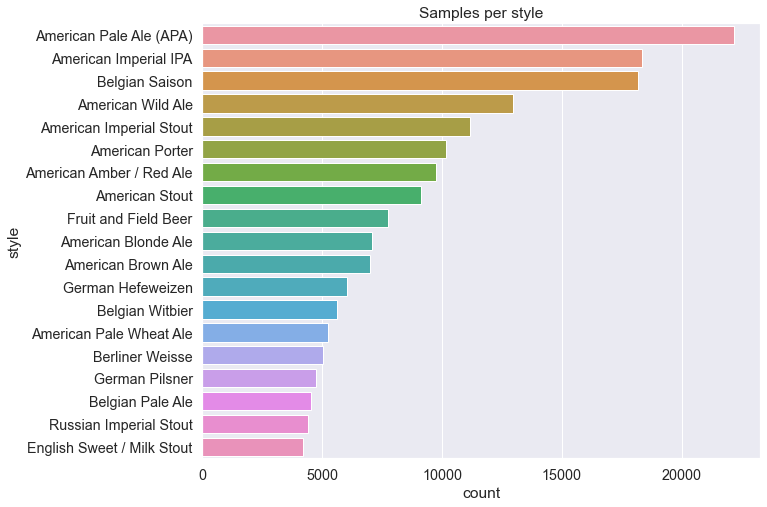

In [5]:
# Counting Beer Styles

def show_styles(data):
    sns.set(font_scale=1.3)
    f, ax = plt.subplots(figsize=(10,8))
    sns.countplot(y = 'style', 
                       data = data,
                      order = data['style'].value_counts(ascending=False).index[1:20]) 
    plt.title('Samples per style') 
    return ax

show_styles(df_beers) ;

In [6]:
beers_20_reviews = list((df_reviews['beer_id'].value_counts()>20).index)
df_beer_scores = df_reviews[df_reviews['beer_id'].isin(beers_20_reviews)].groupby('beer_id').mean()

In [7]:
df_beers = df_beers.join(df_beer_scores)
df_beers=df_beers.dropna(subset=['look', 'smell', 'taste', 'feel', 'overall', 'score'])

In [8]:
df=df_beers.groupby('style')['overall'].mean().nlargest(12).reset_index()

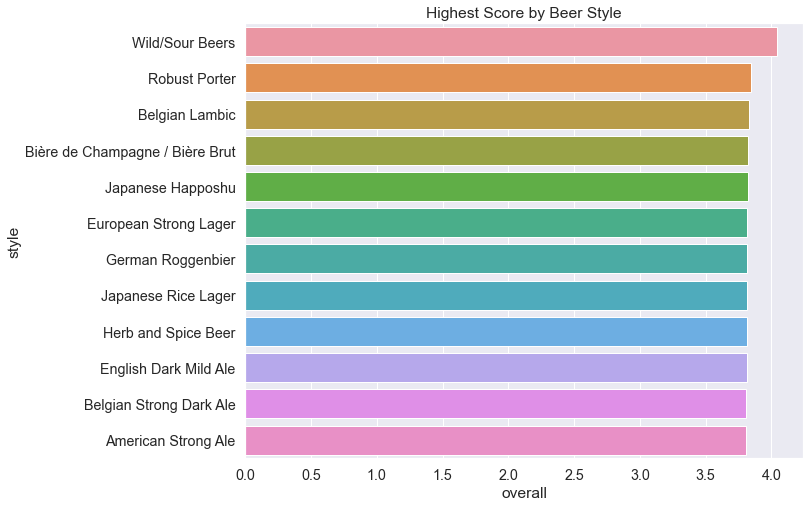

In [9]:
def show_scores_styles(data):
    f, ax = plt.subplots(figsize=(10,8))
    sns.barplot(x='overall',y='style',data=data)
    plt.title('Highest Score by Beer Style')
    return ax

show_scores_styles(df) ;

In [10]:
df=df_beers.groupby('style')['name'].count().nlargest(12).reset_index()

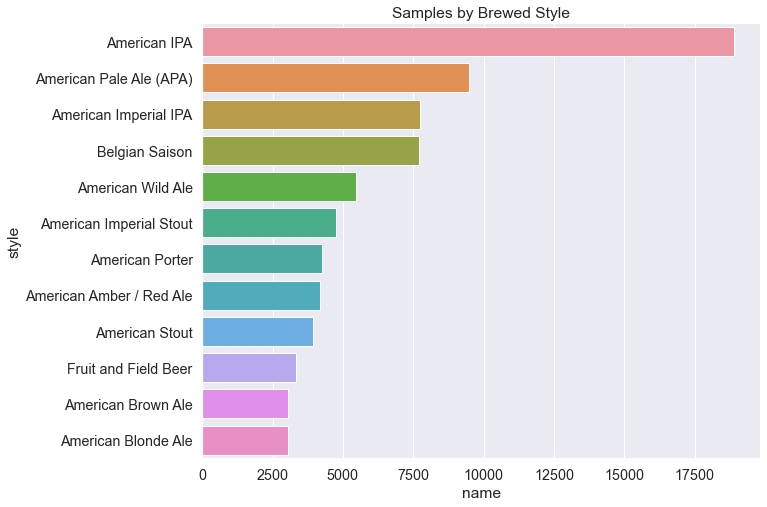

In [11]:
# Counting Brewed Beer Styles

def show_brewed_styles(data):
    f, ax = plt.subplots(figsize=(10,8))
    sns.barplot(x='name',y='style',data=data)
    plt.title('Samples by Brewed Style')
    return ax

show_brewed_styles(df) ;



# Meta Features in Reviews

In [116]:
df_reviews=df_beers_raw.dropna(subset=['text'])

In [117]:
# word_count
df_reviews['word_count'] = df_reviews['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_reviews['unique_word_count'] = df_reviews['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_reviews['stop_word_count'] = df_reviews['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df_reviews['mean_word_length'] = df_reviews['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_reviews['char_count'] = df_reviews['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_reviews['punctuation_count'] = df_reviews['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

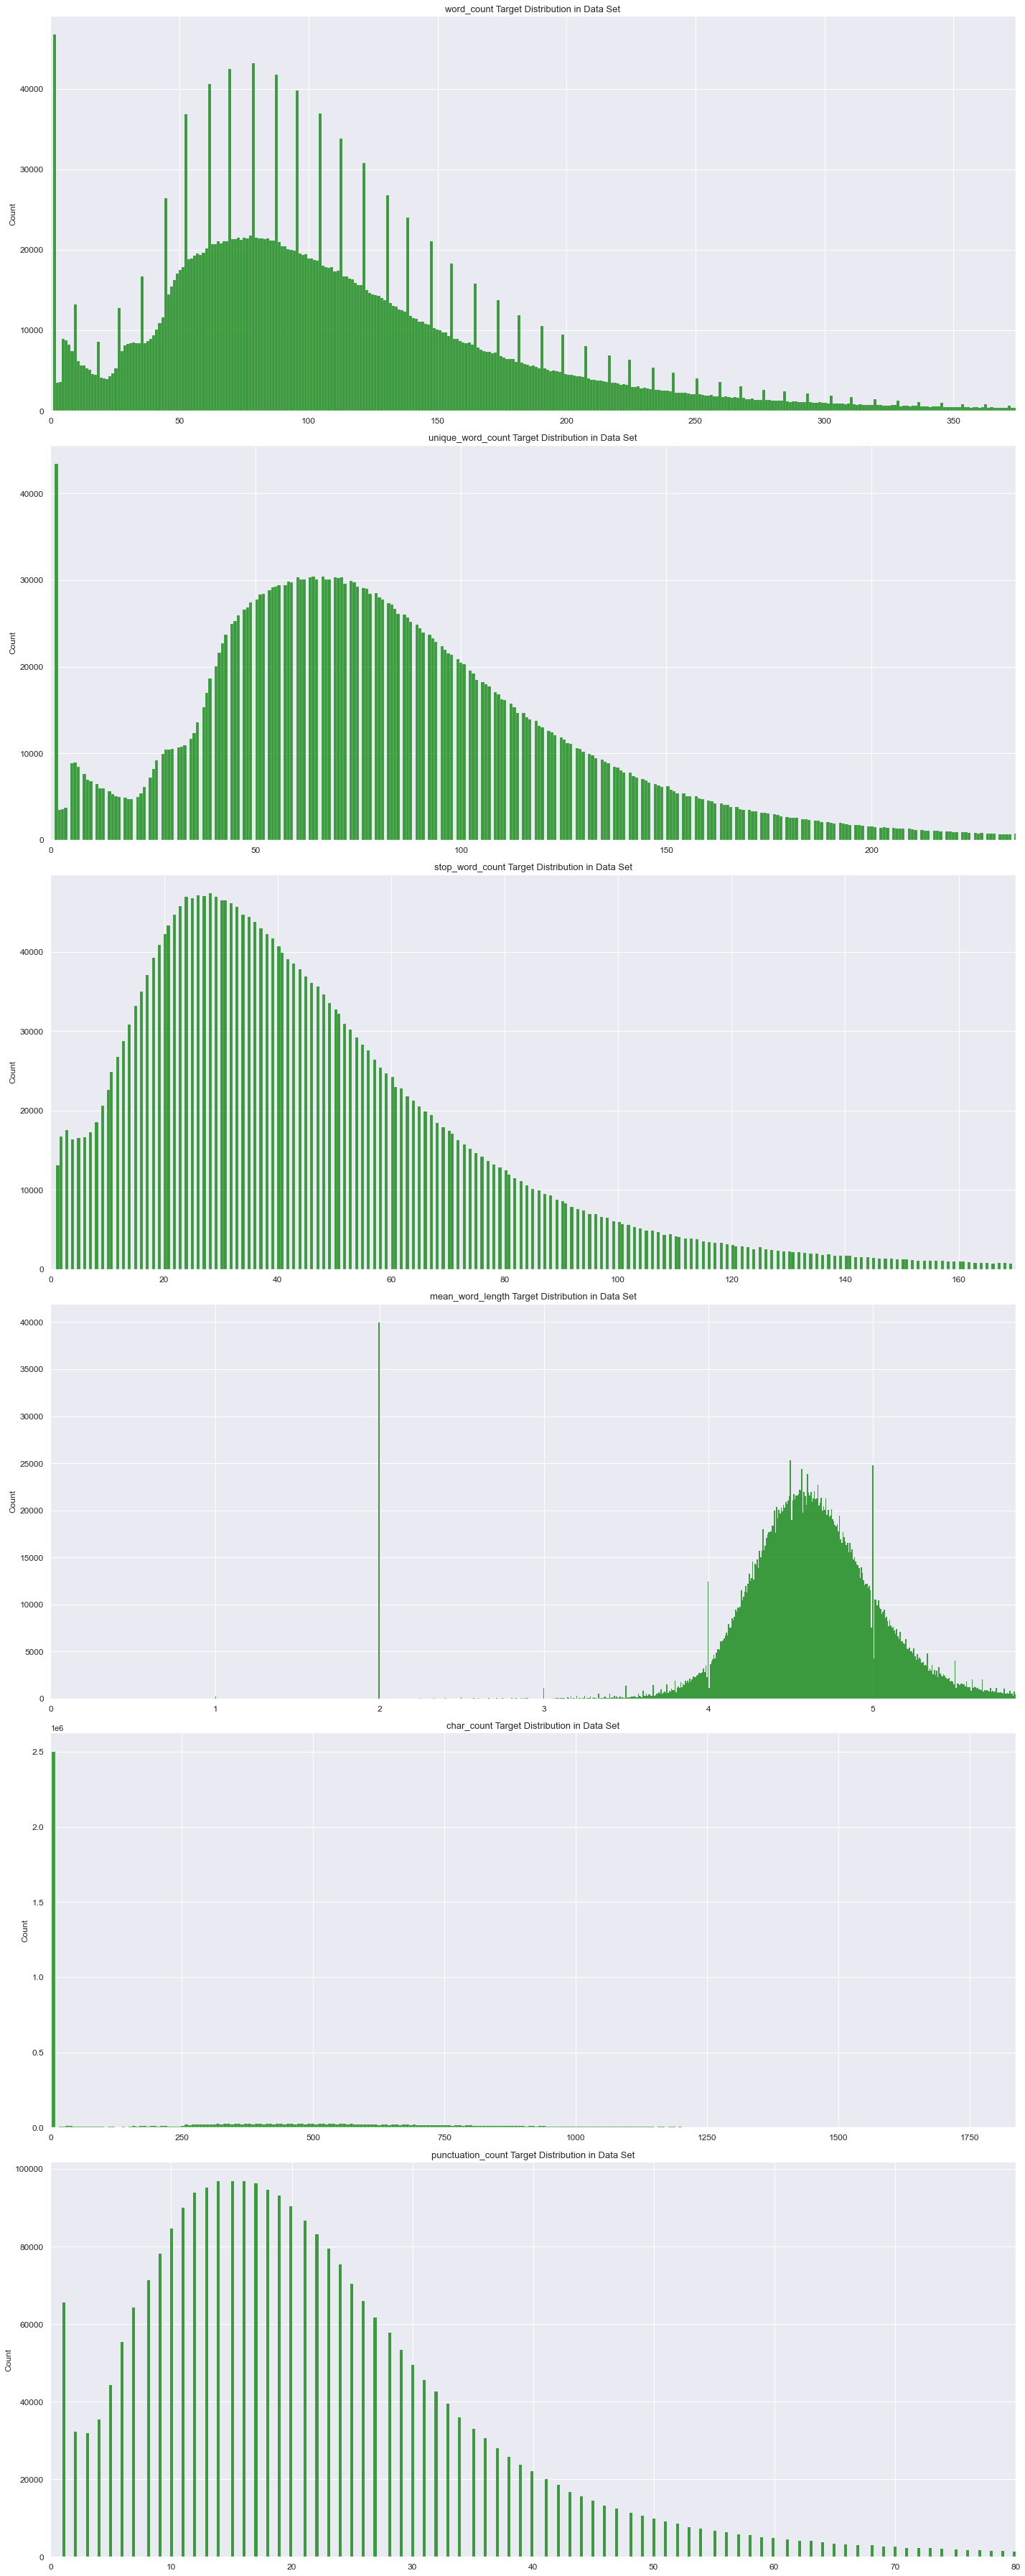

In [136]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                'char_count', 'punctuation_count']

fig, axes = plt.subplots(nrows=len(METAFEATURES), figsize=(20, 50))

for i, feature in enumerate(METAFEATURES):
    df= df_reviews[df_reviews[feature]>0]
    sns.histplot(df[feature], color='green', ax=axes[i])
    
    axes[i].set_xlabel('')
    axes[i].set_xlim(0,df[feature].quantile(0.99))
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_title(f'{feature} Target Distribution in Data Set', fontsize=13)
    plt.tight_layout()
    
plt.show()

In [140]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50

# Unigrams
unigrams = defaultdict(int)

for text in df_reviews['text']:
    for word in generate_ngrams(text):
        unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
bigrams = defaultdict(int)

for text in df_reviews['text']:
    for word in generate_ngrams(text, n_gram=2):
        bigrams[word] += 1
        
df_bigrams = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
trigrams = defaultdict(int)

for text in df_reviews['text']:
    for word in generate_ngrams(text, n_gram=3):
        trigrams[word] += 1
        
df_trigrams = pd.DataFrame(sorted(trigrams.items(), key=lambda x: x[1])[::-1])

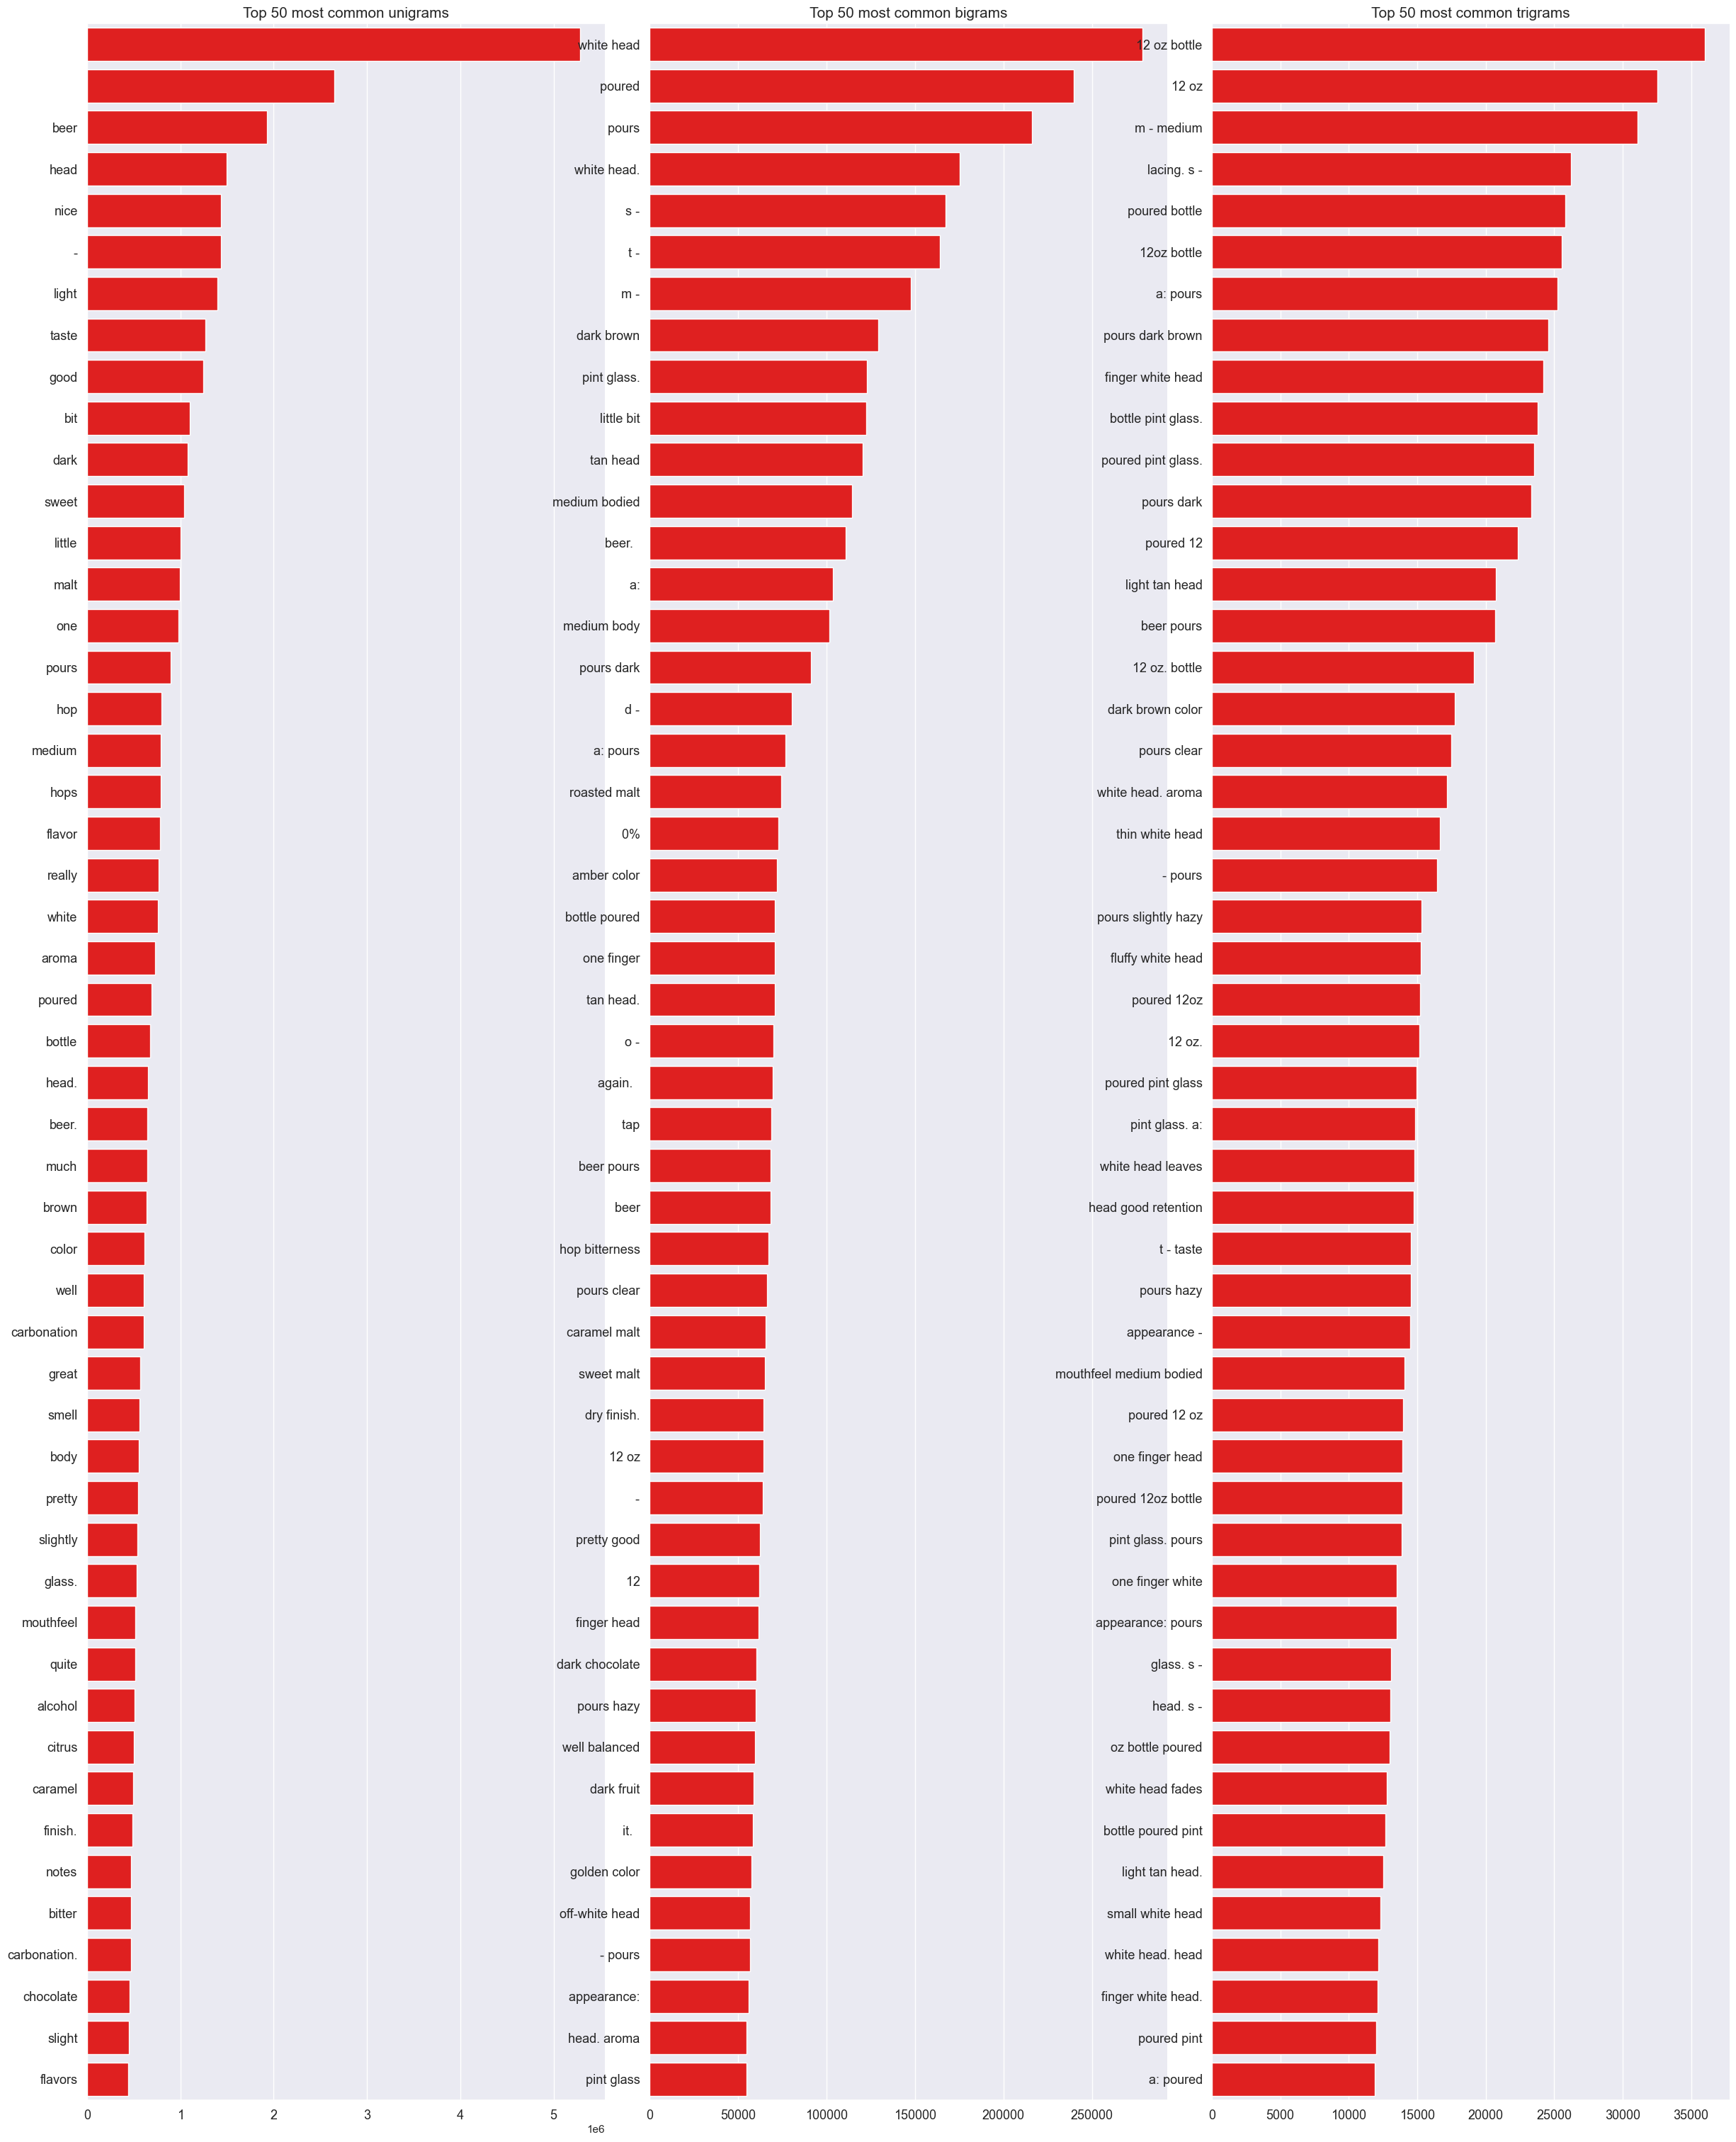

In [141]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 30), dpi=100)


sns.barplot(y=df_unigrams[0].values[:N], x=df_unigrams[1].values[:N], ax=axes[0], color='red')
axes[0].spines['right'].set_visible(False)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=13)
axes[0].tick_params(axis='y', labelsize=13)
axes[0].set_title(f'Top {N} most common unigrams', fontsize=15)

sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes[1], color='red')
axes[1].spines['right'].set_visible(False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)
axes[1].set_title(f'Top {N} most common bigrams', fontsize=15)

sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], ax=axes[2], color='red')
axes[2].spines['right'].set_visible(False)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', labelsize=13)
axes[2].tick_params(axis='y', labelsize=13)
axes[2].set_title(f'Top {N} most common trigrams', fontsize=15)
plt.tight_layout()
plt.show()

# Building classification models

In [10]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from bs4 import BeautifulSoup

In [14]:
df_reviews=pd.read_csv('../datasets/reviews.csv', dtype={'text': 'str'})
df_reviews=df_reviews[['beer_id','text']]

df_reviews['text']=df_reviews['text'].apply(lambda x:  BeautifulSoup(x, "lxml").get_text(strip=True))
df_reviews=df_reviews.dropna(how='any').reset_index(drop=True)

In [22]:
df_reviews=df_reviews[df_reviews['text'].str.strip().astype(bool)].reset_index(drop=True)

In [39]:
beer_ids = list(df_reviews.groupby('beer_id')['text'].count()[(df_reviews.groupby('beer_id')['text'].count()>1000)].index)
df_reviews = df_reviews[df_reviews['beer_id'].isin(beer_ids)].reset_index(drop=True)

In [51]:
df_beers = pd.read_csv('../datasets/beers.csv')
df_beers = df_beers[df_beers['id'].isin(beer_ids)].reset_index(drop=True)
# df_beers.to_csv('../datasets/beers_clean.csv' , index=False)

In [ ]:
df_reviews = df_reviews.merge(df_beers, how='left', left_on = 'beer_id', right_on = 'id')[['beer_id', 'text', 'style']]
# df_reviews.to_csv('../datasets/reviews_clean.csv' , index=False)

In [168]:
#READ

In [167]:
# Read the dataset
df_reviews = pd.read_csv('../datasets/reviews_clean.csv', dtype={'text': 'str'} )
df_beers = pd.read_csv('../datasets/beers_clean.csv')

In [4]:
#Train-test split

In [58]:
X_train_text, X_test_text, y_train_ids, y_test_ids = train_test_split(df_reviews['text'], 
                                                                      df_reviews['beer_id'], 
                                                                      test_size=0.1, 
                                                                      random_state=100
                                                                     )

In [142]:
X_train_text_2, X_test_text_2, y_train_style, y_test_style = train_test_split(df_reviews['text'], 
                                                                      df_reviews['style'], 
                                                                      test_size=0.1, 
                                                                      random_state=100
                                                                     )

In [59]:
traindf=pd.concat([y_train_ids,y_train_style,X_train_text],axis=1)
testdf=pd.concat([y_test_ids,y_test_style, X_test_text],axis=1)

In [60]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train_ids)
y_test = lb.transform(y_test_ids)

In [910]:
# UNIVERSAL SENTENCE ENCODER

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model_use(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [62]:
list(X_train_text[0:3])

['12 oz stubby bottle dated as bottled on December 31st, 2010 at 2:46 PM. Kept refrigerated. Poured into a DFH shaped pint. So it\'s finally time to tackle this mythical beast. After over a year of drinking craft brews, I think I\'ve assembled enough experience to track down the intimidating and formidable Bigfoot. Let\'s just hope it\'s enough drinking experience to tame this wild beast of a barleywine, my first of the style. Pours dark copper with a large and rocky off-white head of almost three fingers. Large head does not equate with a lot of carbonation, though. Lacing very present. Aroma is very deceptive, smells like a bold Sierra Nevada DIPA. Big hop aromas of pine and grassiness with a little citrus. Sweet caramel malt is actually concealed in the back. Certainly a big, bold beer. Super strong malty sweetness in the beginning, bready, fruity, and almost brandy/rum like. The hops take over a bit in the back end, although not as much as the aroma alluded to. The hops are similar

In [63]:
#Getting embeddings for a sentence:
messages =list(X_train_text[0:3])

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)
for i in range(len(messages)):
    print("Message: {}".format(messages[i]))
    # print("Embedding size: {}".format(len(message_embeddings)))
    message_embedding_snippet = ", ".join(
          (str(x) for x in np.array(message_embeddings[i]).tolist()[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: 12 oz stubby bottle dated as bottled on December 31st, 2010 at 2:46 PM. Kept refrigerated. Poured into a DFH shaped pint. So it's finally time to tackle this mythical beast. After over a year of drinking craft brews, I think I've assembled enough experience to track down the intimidating and formidable Bigfoot. Let's just hope it's enough drinking experience to tame this wild beast of a barleywine, my first of the style. Pours dark copper with a large and rocky off-white head of almost three fingers. Large head does not equate with a lot of carbonation, though. Lacing very present. Aroma is very deceptive, smells like a bold Sierra Nevada DIPA. Big hop aromas of pine and grassiness with a little citrus. Sweet caramel malt is actually concealed in the back. Certainly a big, bold beer. Super strong malty sweetness in the beginning, bready, fruity, and almost brandy/rum like. The hops take over a bit in the back end, although not as much as the aroma alluded to. The hops are simi

In [64]:
batch_size=10000
size=X_train_text.shape[0]
i=1
X_train = embed(X_train_text[0:i])
while i<size:
    X_train = tf.concat([X_train, embed(X_train_text[i:min(i+batch_size,size)])], 0)
    i= i+batch_size

In [65]:
batch_size=10000
size=X_test_text.shape[0]
i=1
X_test = embed(X_test_text[0:i])
while i<size:
    X_test = tf.concat([X_test, embed(X_test_text[i:min(i+batch_size,size)])], 0)
    i= i+batch_size

# Logistic regression

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

In [82]:
clf = LogisticRegression()

parameters = {'C':[1, 10]}
classifier = GridSearchCV(clf, parameters)

classifier=classifier.fit(np.array(X_train),y_train)

C:\Users\xps-haydo\.conda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\xps-haydo\.conda\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [125]:
predicted = classifier.predict(np.array(X_train))

In [126]:
traindf['Logistic_pred']=lb.inverse_transform(predicted)

In [127]:
print(classifier.score(np.array(X_train),y_train))

0.31438446603782977


In [129]:
predicted_test = classifier.predict(np.array(X_test))

In [130]:
testdf['Logistic_pred']=lb.inverse_transform(predicted_test)

In [131]:
print(classifier.score(np.array(X_test),y_test))

0.29459580550873676


# Accuracy of top-n predictions

In [128]:
probs = classifier.predict_proba(np.array(X_train))

<AxesSubplot:>

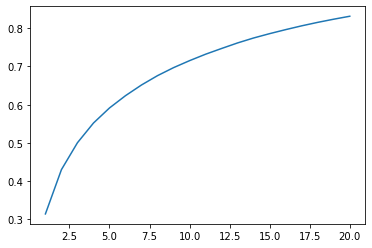

In [123]:
N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_train)):
        if y_train[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_train)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

<AxesSubplot:>

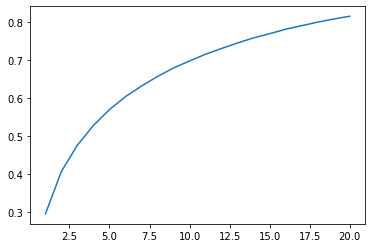

In [133]:
probs = classifier.predict_proba(np.array(X_test))

N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_test)):
        if y_test[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_test)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

# The multinomial Naive Bayes classifier

In [141]:
from sklearn.naive_bayes import  MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [150]:
X_train_scaled = np.array(X_train) - np.array(X_train).min()+0.01 
X_test_scaled = np.array(X_test) - np.array(X_train).min()+0.01

In [151]:
naive = MultinomialNB()
naive.fit(X_train_scaled,y_train)

MultinomialNB()

In [153]:
predicted = naive.predict(X_train_scaled)

traindf['NaiveB_pred']= lb.inverse_transform(predicted)

print(naive.score(X_train_scaled,y_train))

0.03944651607137354


In [154]:
predicted = naive.predict(X_test_scaled)

testdf['NaiveB_pred']= lb.inverse_transform(predicted)

print(naive.score(X_test_scaled,y_test))

0.038147255232446504


# Accuracy of top-n predictions

In [155]:
probs = naive.predict_proba(X_train_scaled)

<AxesSubplot:>

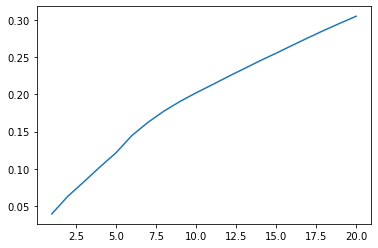

In [156]:
N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_train)):
        if y_train[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_train)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

<AxesSubplot:>

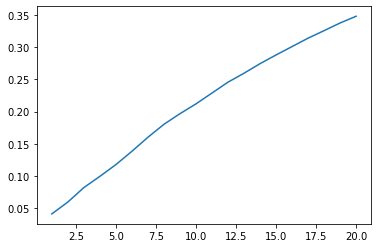

In [157]:
probs = naive.predict_proba(X_test_scaled)

N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_test)):
        if y_test[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_test)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

# Linear Support Vector Classification 

In [11]:
from sklearn.svm import LinearSVC, SVC

In [12]:
lin = LinearSVC()  
lin.fit(X_train,y_train)

LinearSVC()

In [13]:
predicted = lin.predict(X_train)

traindf['LinearSVC_pred']= lb.inverse_transform(predicted)

print(lin.score(X_train,y_train))

0.29236174162057854


In [14]:
predicted = lin.predict(X_test)

testdf['LinearSVC_pred']= lb.inverse_transform(predicted)

print(lin.score(X_test,y_test))

0.2598195045977257


# Accuracy of top-n predictions

In [16]:
predict_proba_dist = lin.decision_function(X_train)

In [17]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [18]:
probs = []
for eachArr in predict_proba_dist:
    probs.append(softmax(eachArr))

<AxesSubplot:>

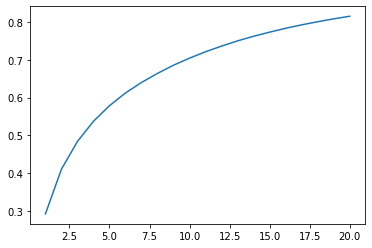

In [23]:
N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_train)):
        if y_train[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_train)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

<AxesSubplot:>

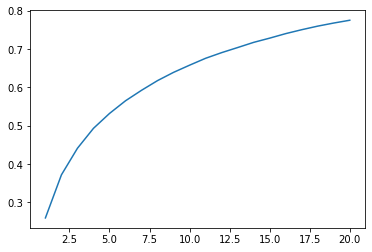

In [24]:
predict_proba_dist = lin.decision_function(X_test)
probs = []
for eachArr in predict_proba_dist:
    probs.append(softmax(eachArr))

N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_test)):
        if y_test[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_test)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

# Support Vector Classification 

In [ ]:
#TOO SLOW - SKIP

In [ ]:
C = 604
gamma = 0.96

clf = SVC(C=float(C), gamma=float(gamma), kernel='rbf',probability = True)
clf.fit(X_train,y_train)

In [ ]:
predicted = clf.predict(X_train)

traindf['SVC_pred']= lb.inverse_transform(predicted)

print(clf.score(X_train,y_train))

In [ ]:
predicted = clf.predict(X_test)

testdf['SVC_pred']= lb.inverse_transform(predicted)

print(clf.score(X_test,y_test))

# Accuracy of top-n predictions

In [155]:
probs = SVC.predict_proba(X_train)

In [ ]:
N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_train)):
        if y_train[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_train)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

In [ ]:
probs = SVC.predict_proba(X_test)

N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_test)):
        if y_test[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_test)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

# XGBoost

In [44]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [45]:
X_train_xgb= np.array(X_train)
X_test_xgb= np.array(X_test)

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# fit model to training data
XGBClf = XGBClassifier(use_label_encoder=False, n_estimators=100, verbosity=1)
XGBClf.fit(X_train_xgb, y_train)

[11:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
predicted = XGBClf.predict(X_train_xgb)

traindf['XGBoost_pred']= lb.inverse_transform(predicted)

# evaluate predictions
accuracy = accuracy_score(y_train, predicted)
print(accuracy)

In [ ]:
predicted = XGBClf.predict(X_test_xgb)

testdf['XGBoost_pred']= lb.inverse_transform(predicted)

# evaluate predictions
accuracy = accuracy_score(y_test, predicted)
print(accuracy)

# Accuracy of top-n predictions

In [155]:
probs = XGBClf.predict_proba(X_train_xgb)

In [ ]:
N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_train)):
        if y_train[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_train)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

In [ ]:
probs = XGBClf.predict_proba(X_test_xgb)

N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_test)):
        if y_test[i] in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_test)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

# Deep Neural Network

In [99]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

In [100]:
enc=OneHotEncoder(sparse=False)
y_train = enc.fit_transform(y_train_ids.values.reshape(-1,1))
y_test = enc.transform(y_test_ids.values.reshape(-1,1))

In [122]:
import dill
# with open("../models/encoder_recommender", "wb") as f: 
#     dill.dump(enc, f)

In [124]:
with open("../models/encoder_recommender", "rb") as fin:
    enc = dill.load(fin)

In [143]:
enc_style=OneHotEncoder(sparse=False)
y_train_2 = enc_style.fit_transform(y_train_style.values.reshape(-1,1))
y_test_2 = enc_style.transform(y_test_style.values.reshape(-1,1))

In [144]:
import dill
# with open("../models/encoder_style", "wb") as f: 
#     dill.dump(enc_style, f)

In [139]:
with open("../models/encoder_style", "rb") as fin:
    enc_style = dill.load(fin)

# DNN 1 (Multi-class Classification)

Last layer's activation function is soft-max and loss function is categorical_crossentropy.

In [105]:
N_Classes =  y_train_ids.nunique()

In [106]:
model = Sequential()

model.add(Dropout(0.2))
model.add(Dense(units=2048,activation='relu' ))

model.add(Dropout(0.2))
model.add(Dense(units=1024,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(units=512,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(units=N_Classes,activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [107]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [108]:
model.fit(x=np.array(X_train), 
          y=y_train,
          batch_size=128,
          epochs=50,
          validation_split=0.1,
          verbose=1,
          callbacks=[early_stop]
         )

Epoch 1/50
3509/3509 [==============================] - 121s 34ms/step - loss: 3.9641 - accuracy: 0.1208 - val_loss: 3.4577 - val_accuracy: 0.1937
Epoch 2/50
3509/3509 [==============================] - 122s 35ms/step - loss: 3.5677 - accuracy: 0.1783 - val_loss: 3.3287 - val_accuracy: 0.2190
Epoch 3/50
3509/3509 [==============================] - 122s 35ms/step - loss: 3.4706 - accuracy: 0.1957 - val_loss: 3.2403 - val_accuracy: 0.2324
Epoch 4/50
3509/3509 [==============================] - 123s 35ms/step - loss: 3.4134 - accuracy: 0.2059 - val_loss: 3.2242 - val_accuracy: 0.2378
Epoch 5/50
3509/3509 [==============================] - 128s 36ms/step - loss: 3.3754 - accuracy: 0.2124 - val_loss: 3.2062 - val_accuracy: 0.2415
Epoch 6/50
3509/3509 [==============================] - 124s 35ms/step - loss: 3.3440 - accuracy: 0.2176 - val_loss: 3.1780 - val_accuracy: 0.2464
Epoch 7/50
3509/3509 [==============================] - 125s 35ms/step - loss: 3.3201 - accuracy: 0.2221 - val_loss: 3

In [109]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

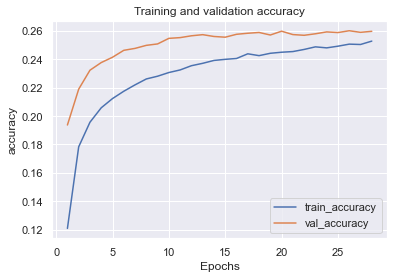

In [110]:
plot_metric(model.history, 'accuracy')

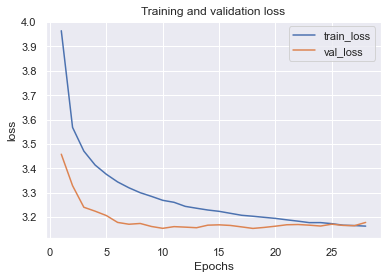

In [111]:
plot_metric(model.history, 'loss')

In [112]:
def my_func(a):
    """Convert probability dist to classification output"""
    return (a == a.max()) * 1

In [113]:
from sklearn.metrics import accuracy_score

In [114]:
predicted = model.predict(X_train)

predicted = np.apply_along_axis(my_func, 1, predicted)

predicted_ids = enc.inverse_transform(predicted)

traindf['DNN1_pred']= predicted_ids

print(accuracy_score(predicted, y_train))

0.32571381614549305


In [115]:
predicted = model.predict(X_test)

predicted = np.apply_along_axis(my_func, 1, predicted)

predicted_ids = enc.inverse_transform(predicted)

testdf['DNN1_pred']= predicted_ids

print(accuracy_score(predicted, y_test))

0.2576932789783181


# Accuracy of top-n predictions

In [975]:
probs = model.predict(X_train[:1])

In [976]:
n=3
top_n = np.argsort(probs)[:,:-n-1:-1]

In [977]:
top_n

array([[177, 242, 108]], dtype=int64)

In [978]:
top_n_ids=[]
for i in top_n[0]:
    vector = np.zeros(probs.shape)
    vector[0][i]=1
    top_n_ids.append(enc.inverse_transform(vector)[0][0])  
top_n_ids

[2671, 20931, 1009]

In [116]:
probs = model.predict(X_train)

<AxesSubplot:>

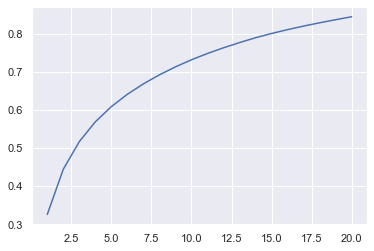

In [117]:
N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_train)):
        if y_train[i].argmax() in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_train)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

<AxesSubplot:>

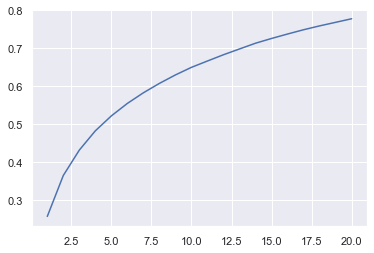

In [118]:
probs = model.predict(X_test)

N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_test)):
        if y_test[i].argmax() in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_test)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

In [119]:
accuracy[0], accuracy[2], accuracy[4], accuracy[9]

(0.2576932789783181,
 0.4322847144557884,
 0.5222951765936722,
 0.6500414877881597)

Save Model

In [126]:
# model.save("../models/model_recommender.h5")

# DNN - TASTE (Multi-label Classification)

In [146]:
N_Classes =  y_train_style.nunique()

In [148]:
model_style = Sequential()

model_style.add(Dropout(0.2))
model_style.add(Dense(units=1024,activation='relu' ))

model_style.add(Dropout(0.2))
model_style.add(Dense(units=256,activation='relu'))

model_style.add(Dropout(0.2))
model_style.add(Dense(units=128,activation='relu'))

model_style.add(Dropout(0.2))
model_style.add(Dense(units=N_Classes,activation='softmax'))

model_style.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [149]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [150]:
model_style.fit(x=np.array(X_train), 
          y=y_train_2,
          batch_size=128,
          epochs=50,
          validation_split=0.1,
          verbose=1,
          callbacks=[early_stop]
         )

Epoch 1/50
3509/3509 [==============================] - 61s 16ms/step - loss: 2.3184 - accuracy: 0.3394 - val_loss: 1.9678 - val_accuracy: 0.4186
Epoch 2/50
3509/3509 [==============================] - 56s 16ms/step - loss: 2.0679 - accuracy: 0.3938 - val_loss: 1.8755 - val_accuracy: 0.4420
Epoch 3/50
3509/3509 [==============================] - 57s 16ms/step - loss: 2.0083 - accuracy: 0.4109 - val_loss: 1.8477 - val_accuracy: 0.4470
Epoch 4/50
3509/3509 [==============================] - 57s 16ms/step - loss: 1.9739 - accuracy: 0.4178 - val_loss: 1.8137 - val_accuracy: 0.4559
Epoch 5/50
3509/3509 [==============================] - 56s 16ms/step - loss: 1.9517 - accuracy: 0.4244 - val_loss: 1.8098 - val_accuracy: 0.4570
Epoch 6/50
3509/3509 [==============================] - 54s 15ms/step - loss: 1.9336 - accuracy: 0.4292 - val_loss: 1.8034 - val_accuracy: 0.4631
Epoch 7/50
3509/3509 [==============================] - 56s 16ms/step - loss: 1.9170 - accuracy: 0.4331 - val_loss: 1.7926 -

In [151]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

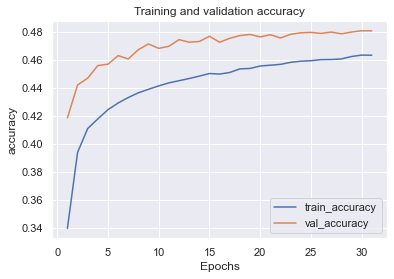

In [152]:
plot_metric(model_style.history, 'accuracy')

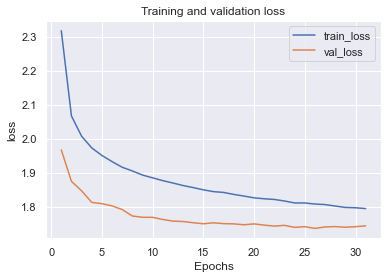

In [153]:
plot_metric(model_style.history, 'loss')

In [154]:
def my_func(a):
    """Convert probability dist to classification output"""
    return (a == a.max()) * 1

In [155]:
from sklearn.metrics import accuracy_score

In [ ]:
predicted = model_style.predict(X_train)

predicted = np.apply_along_axis(my_func, 1, predicted)

predicted_ids = enc_style.inverse_transform(predicted)

traindf['DNN_style_pred']= predicted_ids

print(accuracy_score(predicted, y_train_2))

In [ ]:
predicted = model_style.predict(X_test)

predicted = np.apply_along_axis(my_func, 1, predicted)

predicted_ids = enc_style.inverse_transform(predicted)

testdf['DNN_style_pred']= predicted_ids

print(accuracy_score(predicted, y_test_2))

# Accuracy of top-n predictions

In [1006]:
probs_style = model_style.predict(X_train[:1])
m=6
top_m = np.argsort(probs_style)[:,:-m-1:-1]

top_m_styles=[]
top_m_styles_prob=[]
for i in top_m[0]:
    vector = np.zeros(probs_style.shape)
    vector[0][i]=1
    top_m_styles.append(enc_style.inverse_transform(vector)[0][0]) 
    top_m_styles_prob.append(probs_style[0][i])
top_m_styles_prob = [i/sum(top_m_styles_prob) for i in top_m_styles_prob]

In [1007]:
top_m_styles

['American Barleywine',
 'British Barleywine',
 'American Imperial IPA',
 'American IPA',
 'American Strong Ale',
 'English Old Ale']

In [1008]:
top_m_styles_prob

[0.9989210603830222,
 0.0006759891694391158,
 0.00023701362501050164,
 6.824611618178488e-05,
 6.107085421126095e-05,
 3.6619852135092594e-05]

In [979]:
probs = model_style.predict(X_train[:1])

In [980]:
n=3
top_n = np.argsort(probs)[:,:-n-1:-1]

In [981]:
top_n

array([[ 3, 33,  8]], dtype=int64)

In [983]:
top_n_styles=[]
for i in top_n[0]:
    vector = np.zeros(probs.shape)
    vector[0][i]=1
    top_n_styles.append(enc_style.inverse_transform(vector)[0][0])  
top_n_styles

['American Barleywine', 'British Barleywine', 'American Imperial IPA']

In [156]:
probs = model_style.predict(X_train)

<AxesSubplot:>

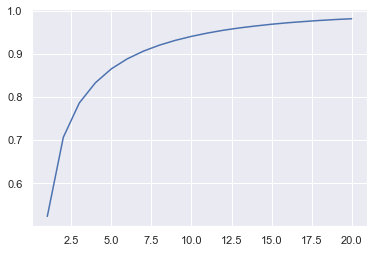

In [157]:
N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_train_2)):
        if y_train_2[i].argmax() in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_train_2)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

<AxesSubplot:>

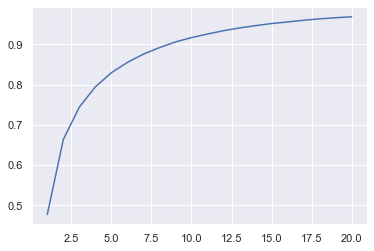

In [159]:
probs = model_style.predict(X_test)

N=20
accuracy=[]

for n in range(1,N+1):
    # Sort desc and only extract the top-N
    top_n = np.argsort(probs)[:,:-n-1:-1]

    # Calculate accuracy
    true_preds = 0
    for i in range(len(y_test_2)):
        if y_test_2[i].argmax() in top_n[i]:
            true_preds += 1
    
    accuracy_n= true_preds/len(y_test_2)
    accuracy.append(accuracy_n)

sns.lineplot(x=range(1,21), y=accuracy)

In [160]:
accuracy[0], accuracy[2], accuracy[4], accuracy[9]

(0.4777769760813882,
 0.7439301562105415,
 0.8293048089757927,
 0.9163750496049641)

Save Model

In [161]:
model_style.save("../models/model_style.h5")

# WordCloud - TfIdf

In [367]:
import wordcloud
# from wordcloud import STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

STOPWORDS = wordcloud.STOPWORDS.add('beer')

In [1068]:
#Corpus
corpus = [str(df_reviews[df_reviews['beer_id'] == beer].text.values) for beer in beer_ids]

In [1069]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .99, min_df = .01, max_features=5000)

SyntaxError: keyword argument repeated (<ipython-input-1069-1e0f65d4757b>, line 1)

In [449]:
X = vectorizer.fit_transform(corpus)

In [450]:
feature_names = vectorizer.get_feature_names()

In [451]:
dense = X.todense()
denselist = dense.tolist()
df_corpus = pd.DataFrame(denselist, columns=feature_names)

In [452]:
data_corpus = df_corpus.transpose()
data_corpus.columns = beer_ids

In [454]:
#save
data_corpus.to_csv("../datasets/data_corpus_tfidf.csv", index=True)
#load
data_corpus=pd.read_csv("../datasets/data_corpus_tfidf.csv", index_col=0, )
data_corpus.columns=[int(col) for col in data_corpus.columns] 

In [455]:
mask = np.array(Image.open('../images/image_mask.jpg'))
# mask_colors = wordcloud.ImageColorGenerator(mask)
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs): return("hsl(0,100%, 1%)")

wc = wordcloud.WordCloud(stopwords=STOPWORDS,
                       mask=mask, background_color="white",
                       max_words=200, max_font_size=256, min_font_size=8,
                       random_state=42, width=mask.shape[1],
                       height=mask.shape[0], 
                       color_func=black_color_func,
                        )

In [456]:
beer=6

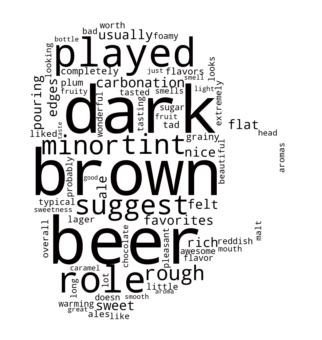

Turbodog
Turbodog is a dark brown ale brewed with Willamette hops and a combination of pale, crystal and chocolate malts. This combination gives Turbodog its rich body and color and a sweet chocolate toffee-like flavor. Turbodog began as a specialty ale but has gained a huge loyal following and has become one of our flagship brews.


In [1085]:
name = df_beers[df_beers.id == beer].name.values[0] 
style= df_beers[df_beers.id == beer]['style'].values[0] 
txt = df_beers[df_beers.id == beer].notes.values[0]

wc.generate_from_frequencies(data_corpus[beer])
plt.figure(figsize=(6,6))
plt.imshow(wc, interpolation="bilinear")

plt.axis('off')
plt.show()
print(name)
print(txt)

# Radar Chart

In [1023]:
top_m_styles

['American Barleywine',
 'British Barleywine',
 'American Imperial IPA',
 'American IPA',
 'American Strong Ale',
 'English Old Ale']

In [1067]:
top_m_styles_prob

[0.9989210603830222,
 0.0006759891694391158,
 0.00023701362501050164,
 6.824611618178488e-05,
 6.107085421126095e-05,
 3.6619852135092594e-05]

In [1065]:
def radar_chart(rates, xticklabels):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111,polar=True)
    N = len(rates)
    radii = 10 * np.random.rand(N)
    colors = plt.cm.viridis(radii / 5.)

     
    if max(rates)>0.9:
        rates = np.log(rates) - min(np.log(rates))
    
    theta = np.arange(0, 2*np.pi, 2*np.pi/N) 
    bars = ax.bar(theta, rates, width=1, color=colors, alpha=0.5)

    ax.set_xticks(theta)
    ax.set_xticklabels(xticklabels)
    ax.yaxis.grid(True)
    ax.set_yticklabels([])
    plt.show()
    

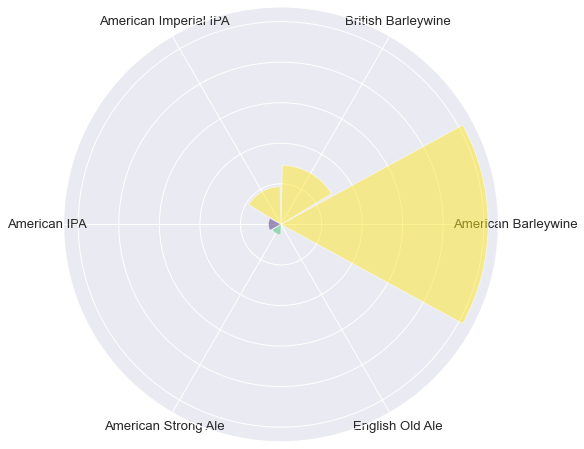

In [1066]:
radar_chart(top_m_styles_prob,top_m_styles)

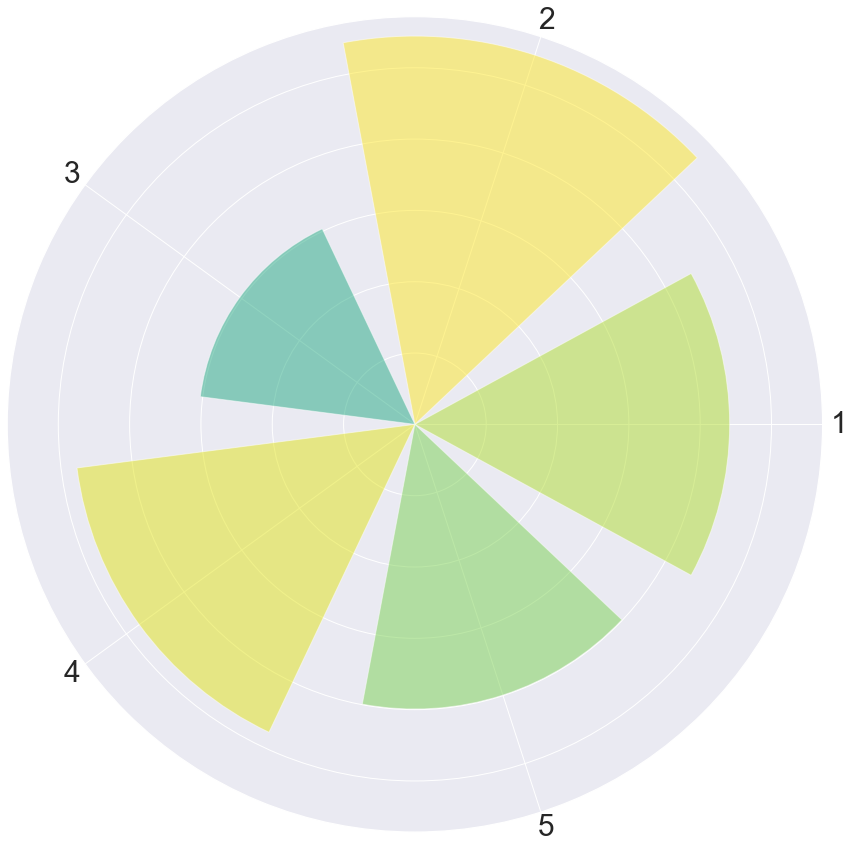

In [1082]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,polar=True)
sample = np.random.uniform(low=0.5, high=13.3, size=(5,))
colors = plt.cm.viridis(sample /10. )


N = len(sample) 

theta = np.arange(0, 2*np.pi, 2*np.pi/N) 
bars = ax.bar(theta, sample, width=1, color=colors, alpha=0.5)


ax.set_xticks(theta)
ax.set_xticklabels(range(1, len(theta)+1), fontsize=30)
ax.yaxis.grid(True)
ax.set_yticklabels([])
plt.show()

# Visualizing Language Similarity in pyvis

In [511]:
import networkx as nx
from pyvis.network import Network

In [557]:
X_encoded = pd.DataFrame(np.concatenate([X_train, X_test], axis=0))

In [559]:
X_encoded['ids'] = np.concatenate([y_train_ids.values.reshape(-1,1),y_test_ids.values.reshape(-1,1)], axis=0  )

In [803]:
X_encoded_mean = X_encoded.groupby('ids').mean().sort_index()

Text(0.5, 1.0, 'Semantic Textual Similarity')

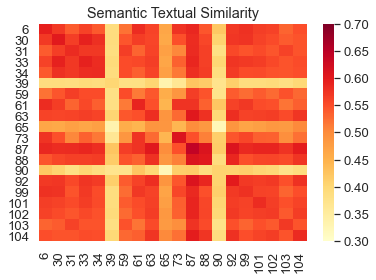

In [612]:
corr = np.inner(X_encoded_mean[:20],X_encoded_mean[:20])
sns.set(font_scale=1.2)

g = sns.heatmap(corr,
            xticklabels=X_encoded_mean[:20].index,
            yticklabels=X_encoded_mean[:20].index,
            vmin=0.3,
            vmax=0.7,
            cmap="YlOrRd")
g.set_xticklabels(X_encoded_mean[:20].index, rotation=90)
g.set_title("Semantic Textual Similarity")

In [805]:
corr = np.inner(X_encoded_mean, X_encoded_mean)
df_similarity = pd.DataFrame(corr, columns=X_encoded_mean.index, index=X_encoded_mean.index)

In [900]:
def my_func_similarity(a, num=2):
    """Filter Similarity Scores"""
    return (a >=  sorted(a, reverse=True)[num-1]) * 1

In [901]:
similarity_matrix = np.array(df_similarity)
np.fill_diagonal(similarity_matrix,0) 
similarity_matrix = np.apply_along_axis(my_func_similarity, 1, similarity_matrix)

In [902]:
graph = nx.from_numpy_matrix(similarity_matrix)

graph = nx.relabel_nodes(graph, dict(enumerate(df_beers.sort_values(by=['id'])['name'].values)))

In [908]:
nt = Network(notebook=True, 
             directed=False, 
             height='600px',
             width='1200px',)
# populates the nodes and edges data structures
nt.from_nx(graph)
nt.show('nx.html')

In [1083]:
df_beers

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,195,Mirror Pond Pale Ale,63,OR,US,American Pale Ale (APA),Year-round,5.00,Alc. by Vol.: 5.0%,f
1,45073,Plead The 5th Imperial Stout,1471,MI,US,Russian Imperial Stout,Rotating,11.00,2010 and pre: white label,f
2,1493,Sweetwater IPA,273,GA,US,American IPA,Year-round,6.30,"This mammoth IPA is dry-hopped to the gills, d...",f
3,6,Turbodog,3,LA,US,English Brown Ale,Year-round,5.60,Turbodog is a dark brown ale brewed with Willa...,f
4,30,Trois Pistoles,22,QC,CA,Belgian Strong Dark Ale,Year-round,9.00,"Drawing on Quebec folklore, Unibroue chose the...",f
...,...,...,...,...,...,...,...,...,...,...
325,50697,Double Jack,2210,CA,US,American Imperial IPA,Year-round,9.50,No notes at this time.,t
326,55939,Hoptimum,140,CA,US,American Imperial IPA,Rotating,9.60,A group of hop-heads and publicans challenged ...,f
327,74986,Lagunitas Sucks,220,CA,US,American Imperial IPA,Year-round,7.85,This sad holiday season we didn’t have the bre...,f
328,76816,Sierra Nevada Ruthless Rye IPA,140,CA,US,Rye Beer,Spring,6.60,"Rugged and resilient, rye has been a staple gr...",f
